# Transformer Implementation

For the fun of it, let's implement a transformer in PyTorch following the original paper by [Vaswani et al. (2017)](https://arxiv.org/abs/1706.03762).

What are the necessary steps?

* Attention layer

* Multi-head attention

* Attention block

* Encoder/decoder

* Embedding

* Positional encoding

* Training (on M2)

* Data

## 1. Data

Let's actually start with obtaining data from the PyTorch tutorial: https://pytorch.org/tutorials/beginner/translation_transformer.html

First, getting the tokenizer and building the vocabulary:

In [1]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List

In [2]:
# We need to modify the URLs for the dataset since the links to the original dataset are broken
# Refer to https://github.com/pytorch/text/issues/1756#issuecomment-1163664163 for more info
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}

In [3]:
# %%bash
# pip install torchdata
# pip install spacy
# python -m spacy download en_core_web_sm
# python -m spacy download de_core_news_sm

In [4]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

In [5]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3

# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

In [6]:
# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

In [7]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

In [8]:
# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

Collation function converts batch of raw strings into batch tensors:

In [9]:
from torch.nn.utils.rnn import pad_sequence

In [10]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

In [11]:
# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

In [12]:
# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor

In [13]:
# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

Next, let's get some data to actually know the inputs and targets of the transformer:

In [14]:
import torch

In [15]:
from torch.utils.data import DataLoader

In [16]:
train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))

In [17]:
BATCH_SIZE = 128

In [18]:
train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [19]:
for src, tgt in train_dataloader:
    break

In [20]:
src.shape

torch.Size([27, 128])

In [21]:
tgt.shape

torch.Size([24, 128])

In [22]:
tgt[:,0]

tensor([   2,   19,   25,   15, 1169,  808,   17,   57,   84,  336, 1339,    5,
           3,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1])

How to use tokenizer and vocab:

In [23]:
token_transform['de']("Hallo wie geht's dir? Denkst du manchmal an mich?")

['Hallo',
 'wie',
 "geht's",
 'dir',
 '?',
 'Denkst',
 'du',
 'manchmal',
 'an',
 'mich',
 '?']

In [25]:
vocab_transform['de'].get_itos()

['<unk>',
 '<pad>',
 '<bos>',
 '<eos>',
 '.',
 'Ein',
 'einem',
 'in',
 ',',
 'und',
 'mit',
 'auf',
 'Mann',
 'einer',
 'Eine',
 'ein',
 'der',
 'Frau',
 'eine',
 'die',
 'einen',
 'Zwei',
 'im',
 'an',
 'von',
 'sich',
 'dem',
 'Mädchen',
 'vor',
 'zu',
 'steht',
 'Männer',
 'sitzt',
 'Hund',
 'den',
 'Junge',
 'Straße',
 'während',
 'Gruppe',
 'hält',
 'spielt',
 'Hemd',
 'Personen',
 'über',
 'das',
 'eines',
 'Frauen',
 'blauen',
 'ist',
 'neben',
 'Kind',
 'roten',
 'weißen',
 'stehen',
 'Menschen',
 'aus',
 'am',
 'sitzen',
 'durch',
 'spielen',
 'Drei',
 'geht',
 'trägt',
 'bei',
 'fährt',
 'Wasser',
 'um',
 'Kinder',
 'Person',
 'kleines',
 'macht',
 'springt',
 'schwarzen',
 'entlang',
 'zwei',
 'kleiner',
 'Leute',
 'gehen',
 'etwas',
 'seinem',
 'großen',
 'Oberteil',
 'Hand',
 'grünen',
 'Mehrere',
 'junge',
 'läuft',
 'sind',
 'Der',
 'Hintergrund',
 'Fahrrad',
 'für',
 'Jungen',
 'Jacke',
 'Freien',
 'Luft',
 'Strand',
 'Ball',
 'hat',
 'anderen',
 'schaut',
 'Kleidung',

In [26]:
vocab_transform['de']['mich']

17747

## 2. Model

Let's go over the paper and discuss the model architecture and the required components:

* Encoder-decoder architecture

* Encoder: mapping of symbol representations ($x \in \mathbb{N}^n$) to continuous representations ($z \in \mathbb{R}^n$)

    * Input embedding: $d_{model} = 512$
 
    * Positional encoding
 
    * Attention block ($N=6$):
 
        * Multi-head self-attention
     
        * Residual connection
     
        * Layer normalization
     
        * Feed forward (fully-connected, position-wise)

* Decoder: auto-regressive generation of output sequence ($y \in \mathbb{N}^m$) based on $z$ and $y_{1}$ to $y_{i-1}$

    * Output embedding
 
    * Positional encoding
 
    * Attention block ($N=6$):
 
        * Masked multi-head self-attention
     
        * Residual connection
     
        * Layer normalization
     
        * Multi-head attention over encoder output
     
        * Feed forward (fully-connected, position-wise)
     
            * Single hidden layer with $d_{ff} = 2048$ and ReLU activation
         
            * Same parameters across positions, different parameters across layers
     
* Attention layer:

    * Mapping of query and key-value pairs to an output: $Q \in \mathbb{R}^{d_q}$, $K \in \mathbb{R}^{d_k}$ and $V \in \mathbb{R}^{d_v}$
 
    * Scaled dot-product attention: $\text{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V$
 
        * Masking to prevent information flow in decoder: setting values to minus infinity prior to softmax function
 
    * Multi-head attention ($h = 8$, $d_k = d_v = d_{model}/h = 64$):
 
        * Instead of single attention function with dimension $d_{model}$, $h$ attention functions with dimensions $d_q = d_k$, $d_k$ and $d_v$

        * Concatenation of $h$ outputs of dimension $d_v$ and linear layer to dimension $d_o$
     
        * Weights: $W^Q \in \mathbb{R}^{d_{model} \times d_k}$, $W^K \in \mathbb{R}^{d_{model} \times d_k}$, $W^V \in \mathbb{R}^{d_{model} \times d_v}$ and $W^O \in \mathbb{R}^{h d_v \times d_{model}}$
     
* Embedding ($d_{emb} = d_{model}$):

    * Same weight matrix between the two embeddings layers and the pre-softmax linear transformation
 
    * In embeddings layers weights are multiplied by $\sqrt{d_{model}}$

* Encoding ($d_{enc} = d_{model}$):

    * $\text{enc}(pos, 2i) = \sin(pos/10000^{2i/d_{model}})$
 
    * $\text{enc}(pos, 2i+1) = \cos(pos/10000^{2i/d_{model}})$


Positional encoding:

In [27]:
%matplotlib ipympl

In [28]:
import matplotlib.pyplot as plt

In [29]:
ns = 20
nb = 12
dm = 32

In [30]:
X = torch.ones(ns, nb, dm)

In [31]:
pos = torch.arange(X.shape[0]).repeat(X.shape[-1],1).T
idx = torch.arange(X.shape[-1]).repeat(X.shape[0],1)

In [32]:
res = torch.sin(pos / 10000**((idx-torch.remainder(idx,2))/X.shape[-1]) + torch.remainder(idx,2) * torch.pi/2)

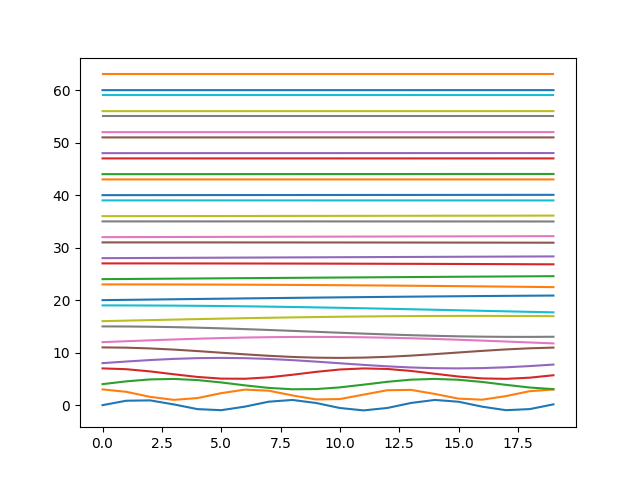

In [35]:
fig, ax = plt.subplots()

for d in range(dm):
    ax.plot(pos[:,d], 2*d + res[:,d])

plt.show()

In [36]:
import math

In [37]:
# reference
max_len = ns
d_model = dm
position = torch.arange(max_len).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2) * -math.log(10000.0) / d_model)
pe = torch.zeros(max_len, 1, d_model)
pe[:, 0, 0::2] = torch.sin(position * div_term)
pe[:, 0, 1::2] = torch.cos(position * div_term)

In [38]:
torch.max(torch.abs(pe[:,0,:] - res))

tensor(9.5367e-07)

In [39]:
torch.allclose(pe[:,0,:], res, atol=1e-06)

True

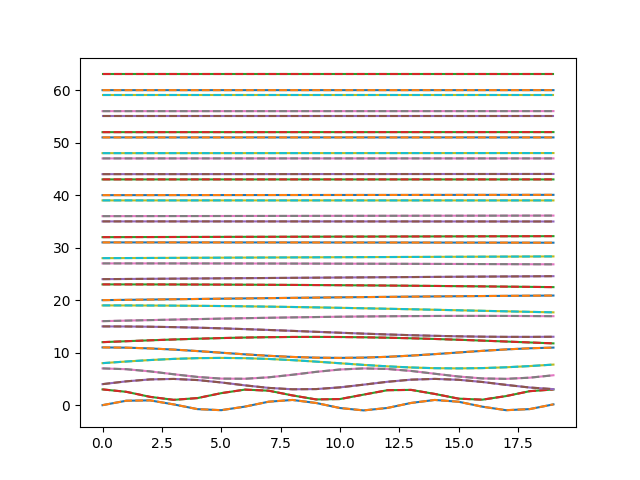

In [40]:
fig, ax = plt.subplots()

for d in range(dm):
    ax.plot(pos[:,d], 2*d + res[:,d])
    ax.plot(pos[:,d], 2*d + pe[:,0,d], '--')

plt.show()

## 3. Tutorial

Compare to [tutorial](https://github.com/pytorch/tutorials/blob/main/beginner_source/translation_transformer.py) PyTorch implementation:

* Positional encoding: calculated only once, then stored

* Embedding: actually multiplying by `sqrt(emb_size)`

* Seed

* Transformer:

    * Send model to device
 
    * Model receives target sentence for training (that's actually a key difference!)
 
    * Model receives masks:

        * `src_mask`: the additive mask for the src sequence (only zeros)
        
        * `tgt_mask`: the additive mask for the encoder output (correct)
          
        * `src_padding_mask`: the Tensor mask for src keys per batch
          
        * `tgt_padding_mask`: the Tensor mask for tgt keys per batch
          
        * `src_padding_mask` as `memory_key_padding_mask`: the Tensor mask for memory keys per batch
     
        * In summary: don't attend to padding tokens

    * Model uses biases for `Q`, `K`, `V`, `O` weights
 
    * Model uses another LayerNorm around both the encoder and decoder
     
    * Model outputs logits, not probabilities (otherwise `softmax` is calculated twice with `CrossEntropyLoss`)

* Loss: `loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)`, no label smoothing

* Optimizer: no scheduler

* Training loop:

    *  Epochs: 18
 
    *  Epoch:
 
        * Create data loader in every epoch
     
        * Send data to device  
 
    *  Validation loss

Study padding mask:

* Source: https://medium.com/mlearning-ai/how-do-self-attention-masks-work-72ed9382510f

* Where do we need key/padding masks?
    
    * Encoder: model(X) does self-attention, needs padding mask aka `X_mask`

        ```
             k1 k2 k3 pd pd
          q1 0  0  0  -I -I
          q2 0  0  0  -I -I
          q3 0  0  0  -I -I
          pd 0  0  0  -I -I
          pd 0  0  0  -I -I


        ```
    
        * If we are doing self-attention only, if there's a `pd` in the input, there will be padding in the output and this will be ignored in the loss due to `ignore_index=train_params['ignore_idx']`
     
        * The MLP is position-/point-wise
     
        * Layer norms normalize not over batches, but over features and words. However, the transformer-specific norm seems to normalize only over features
        
    * Decoder: model(X,Y) does self-attention(X) and attention(X,Y), needs padding mask and peeking mask

        ```
          peeking:                 padding:
             k1 k2 k3 pd pd        k1 k2 k3 pd pd
          q1 0  -I -I -I -I        0  0  0  -I -I
          q2 0  0  -I -I -I        0  0  0  -I -I
          q3 0  0  0  -I -I    +   0  0  0  -I -I
          q4 0  0  0  0  -I        0  0  0  -I -I
          pd 0  0  0  0  0         0  0  0  -I -I


        ```

        * If `pd` is in the query, there will be a `pd` in the target, as there's no other symbol every occuring after `pd`

## 4. Next steps

* Analyze `second_model.pt` training results

* Write translation function

Are there any other next steps?

## Appendix

Save debugging code:

In [ ]:
model.eval()
transformer.eval()

# # checks:
# # embedding
# X1 = model.in_emb(src) * math.sqrt(model.in_emb.weight.shape[1])
# Y1 = model.out_emb(tgt[:-1]) * math.sqrt(model.out_emb.weight.shape[1])
# X2 = transformer.src_tok_emb(src)
# Y2 = transformer.tgt_tok_emb(tgt[:-1])
# assert((X1 == X2).all())
# assert((Y1 == Y2).all())

# # positional encoding
# # X1 += model.pos_enc(X1)
# X1 += transformer.positional_encoding.pos_embedding[:X1.size(0), :]
# Y1 += transformer.positional_encoding.pos_embedding[:Y1.size(0), :]
# X2 = transformer.positional_encoding(X2)
# Y2 = transformer.positional_encoding(Y2)
# assert((X1 == X2).all())
# assert((Y1 == Y2).all())

# # masks
# X1_mask = (src == model.ptok)
# Y1_mask = (tgt[:-1] == model.ptok)

# src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt[:-1])

# # encoder
# for layer in model.encoder:
#     X1 = layer(X1, mask1=X1_mask)
# X1 = model.enc_norm(X1)

# X2 = transformer.transformer.encoder(X2, mask=src_mask, src_key_padding_mask=src_padding_mask)
# # assert((X1 == X2).all())

# # # decoder layer 0 step: works
# # # res = Y1
# # # model.decoder[0].self_attention.attention.mask = False
# # Y1 = model.decoder[0].self_attention(Y1, key_mask=Y1_mask)
# # # Y1 = self.norms[0](Y1 + res)

# # # Y2 = transformer.transformer.decoder.layers[0]._sa_block(Y2, src_mask[:23,:23], tgt_padding_mask, None)
# # Y2 = transformer.transformer.decoder.layers[0]._sa_block(Y2, tgt_mask, tgt_padding_mask, None)

# # # decoder layer 0: works
# # Y1 = model.decoder[0](Y1, X1, mask1=Y1_mask, mask2=X1_mask)

# # Y2 = transformer.transformer.decoder.layers[0](Y2, X2, tgt_mask=tgt_mask, memory_mask=None, tgt_key_padding_mask=tgt_padding_mask, memory_key_padding_mask=src_padding_mask)
                                          
# #                                           src_key_padding_mask=src_padding_mask)

# # output = self.decoder(tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask,
# #                       tgt_key_padding_mask=tgt_key_padding_mask,
# #                       memory_key_padding_mask=memory_key_padding_mask,
# #                       tgt_is_causal=tgt_is_causal, memory_is_causal=memory_is_causal)

# # def forward(tgt: Tensor,  memory: Tensor,    tgt_mask: Optional[Tensor] = None,    memory_mask: Optional[Tensor] = None, tgt_key_padding_mask: Optional[Tensor] = None,
# # memory_key_padding_mask: Optional[Tensor] = None,  tgt_is_causal: bool = False,   memory_is_causal: bool = False, ) -> Tensor:
    
# # x = self.norm1(x + self._sa_block(x, tgt_mask, tgt_key_padding_mask, tgt_is_causal))
# # x = self.norm2(x + self._mha_block(x, memory, memory_mask, memory_key_padding_mask, memory_is_causal))
# # x = self.norm3(x + self._ff_block(x))

# # decoder
# for l, layer in enumerate(model.decoder):
#     Y1 = layer(Y1, X1, mask1=Y1_mask, mask2=X1_mask)
#     # Y2 = transformer.transformer.decoder.layers[l](Y2, X2, tgt_mask=tgt_mask, memory_mask=None, tgt_key_padding_mask=tgt_padding_mask, memory_key_padding_mask=src_padding_mask)
#     # print((Y1-Y2).abs().max())

# Y1 = model.dec_norm(Y1)
# # Y1 = model.linear(Y1)
# # Y2 = transformer.transformer.decoder.norm(Y2)

# Y2 = transformer.transformer.decoder(Y2, X2, tgt_mask=tgt_mask, memory_mask=None, tgt_key_padding_mask=tgt_padding_mask, memory_key_padding_mask=src_padding_mask)
# # Y2 = transformer.generator(Y2)     
                                
# print((Y1-Y2).abs().max())

# # Y1 = model.dec_norm(Y1)
# # Y2 = transformer.transformer(X2, Y2, src_mask, tgt_mask, None, src_padding_mask, tgt_padding_mask, src_padding_mask)


# #         mask=src_mask, src_key_padding_mask=src_key_padding_mask, is_causal=src_is_causal

# #                               src_mask, tgt_mask,             src_padding_mask, tgt_padding_mask, src_padding_mask
# #              (src     tgt     src_mask tgt_mask  memory_mask  src_key_padding_mask tgt_key_padding_mask,   memory_key_padding_mask  src_is_causal tgt_is_causal: memory_is_causal
# # transformer(src_emb, tgt_emb, src_mask, tgt_mask  None,          src_padding_mask, tgt_padding_mask,       memory_key_padding_mask)